## Classifying speakers from raw audio


<div class="alert alert-success">

### The task
    
In this assignment, you will use Python to apply machine learning techniques to audio data. **The task is, given an audio clip from one of two speakers, use a classifier to predict the speaker.**

Why is this useful? Consider multiple people living together with a smart speaker device in one of the rooms. If someone asks the smart speaker what meetings they have on that day, the smart speaker must identify who is speaking before consulting their calendar.

To solve this task, you will first convert audio from time to frequency using the Fast Fourier transform, and then perform Principal Component Analysis (PCA) to bring the dimensionality of the data down from 4001D to 2D so that it can be visualised. Then, you will apply $k$-nearest neighbours ($k$-NN) and a linear classifier and compare their performance.
   

### The format 

The assignment takes the form of a Python notebook and we expect this to take you around 4 hours. As you work through the notebook, there will be **blank cells where you need to code up solutions to problems.** The number of marks available is given after each question. 

**Marks are given for both solving the problems, and for well-commented code. There are 20 marks in total.**


You should code up your answers in the blank cells partitioned using blue lines, like this:

<hr style="border:2px solid blue"> </hr>

**Write your code in the box between the blue lines.**

<hr style="border:2px solid blue"> </hr>

When you are done, save the notebook and submit your assignment through the "Assignments" tab on Notable. See https://media.ed.ac.uk/media/Student%20Guide%20to%20using%20Noteable%20for%20Assingments/1_3zkxza4m for a video showing you how to do this.




</div>
<div class="alert alert-danger">
<b>Before you submit, ensure that the notebook can be run from start to finish by pressing the "Restart & Run All" option in the "Kernel" menu above. If the code doesn't run then you will not be awarded any marks.</b>
</div>
<hr style="border:2px solid black"> </hr>


This assignment has 4 sections. **You are strongly encouraged to reuse, and build on code provided in the course notebook**. This assignment should be an exercise in doing useful things with data, rather than a test of your coding ability.


These sections are:

1. Representing data
2. Principal Component Analysis
3. $k$-Nearest Neighbour classification
4. Linear classification

### 1. Representing Audio Data
We will represent each data point as a vector $\mathbf{x}\in \mathbb{R}^{D}$. This means we have a vector that consists of $D$ real numbers. We can use **NumPy arrays** to represent these vectors. Let's create an example array:

In [1]:
# Import the numpy package
import numpy as np

# This creates a NumPy array which represents a 3D vector
x = np.array([1, 2, 3])

print(f"We have created x which looks like {x}")
print(f"It has {len(x)} elements")

We have created x which looks like [1 2 3]
It has 3 elements


We can use indexing to grab individual elements. **Remember in Python we count from 0.**

In [2]:
print(f"The 0th element in x is {x[0]}")

The 0th element in x is 1


We can represent lots of things in this manner. In this assignment we will consider **audio signals**.

#### 1a. Representing Audio in time

Audio can be encoded in multiple formats e.g. mp3, mp4. A common format is wav. The SciPy library has functions for reading in `.wav` files as NumPy arrays. We will now read in an audio clip of someone speaking.



In [3]:
# Matplotlib for plotting and scipy for reading audio
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav

# Read in a wav file
rate, data = wav.read("recordings/7_jackson_30.wav")

We have now got two variables called `rate` and `data` by reading a `.wav` file.

`rate` is the sample rate of the audio signal. When you hear audio through a computer, although it sounds continous, it is actually **discrete**. The sample rate is the frequency at which the audio was recorded.

In [4]:
print(f"The sample rate is {rate} Hz")

The sample rate is 8000 Hz


`data` is a vector represented by a NumPy array. Let's see how many elements it has, and listen to the sample.

In [5]:
from IPython.display import Audio

print(f'data has {len(data)} elements.')
Audio(data, rate=rate)


data has 3706 elements.


Each of these elements corresponds to a **sample**.

The 0th element is a sample at 0 seconds. The sample rate is 8000Hz which means there are $\frac{1}{8000}$ seconds between each sample.

It follows that the 1st element is a sample at $\frac{1}{8000}$ seconds , the 2nd element is a sample at $\frac{2}{8000}$ seconds and so on. 

What exactly is being sampled? It's the **magnitude** of the audio -- how loud it is!


In [6]:
print(f"The magnitude of the 100th sample is {data[100]}")
print(f"The magnitude of the 1000th sample is {data[1000]}")

The magnitude of the 100th sample is -579
The magnitude of the 1000th sample is -1068


Why are we getting large negative numbers? This is down to how the audio was encoded (there exist many formats within wav). For our purposes this **isn't important** as we are interested in relative values.


<hr style="border:2px solid blue"> </hr>


**Q1: Write code to calculate the length of this audio clip (in seconds), given `rate` and `data`. Assign this length this to a variable called `time`.**

**[2 marks]**



In [7]:
"""Write your solution here. You must use the correct variable name to get marks."""
time = len(data)/rate

In [8]:
"""You can run this cell to check your answer"""
try:
    print(f"time = {time}s")
except NameError:
    print("The variable time does not exist")


time = 0.46325s


<hr style="border:2px solid blue"> </hr>


Let's plot our audio magnitudes against time.

Text(0.5, 1.0, 'Speech Sample')

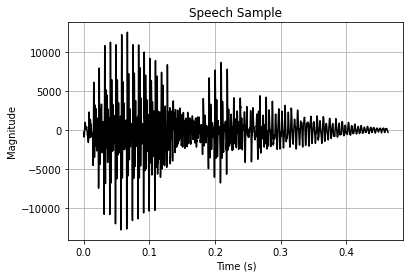

In [9]:
plt.plot(np.linspace(0, time, len(data)), data, "k")  # Plot data against time values.
plt.xlabel("Time (s)")  # Add x label
plt.ylabel("Magnitude")  # Add y label
plt.xticks(size=10)  # Make ticks bigger
plt.yticks(size=10)  # Make ticks bigger
plt.grid()  # Add a grid
plt.title("Speech Sample")  # Add a title

#### 1b. Representing Audio in frequency

We can use the Fast Fourier Transform (FFT) to convert our signal in time into a signal in frequency. This is a more robust representation for speaker classification. Imagine for instance, the same audio clip but delayed by a few seconds. It would look very different in time, but would still have the same frequency components.

We can perform this in SciPy using `rfft`. We wil then take the magnitude of this transformation as we are not interested in phase for our purposes.


In [10]:
from scipy.fft import rfft  # SciPy lets us do a fast Fourier Transform (FFT)

data_freq = rfft(data, n=rate)  # Take the real FFT of our data.
data_freq = np.abs(data_freq)  # We're interested in the magnitude.

print(f"We now have our data in frequency. It has {len(data_freq)} elements.")
print(data_freq)

We now have our data in frequency. It has 4001 elements.
[1908.          808.82418808 2899.0533111  ... 1909.03267439 2381.32821474
 2414.        ]


We have transformed a vector of magnitudes at time points into a vector of magnitudes at frequencies. But what are these frequencies exactly? Well, the Nyquist–Shannon sampling theorem tells us that if we sample at frequency $f$, then we are able to observe frequencies up to $f/2$.

We know that our audio clip was sampled at 8000Hz, so with the FFT we are observing frequencies up to 4000Hz. We input the sample rate to `rfft` and it has returned a 4001-D output. The elements of this output are the magnitudes of the frequencies at 0Hz, 1Hz, 2Hz, ... all the way up to 4000Hz. Let's plot this signal:

Text(0.5, 1.0, 'FFT of Speech Sample')

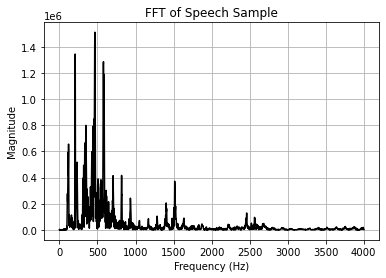

In [11]:
# Get all the individual frequencies for which there are magnitudes. 0-4000Hz inclusive.
freq_values = np.linspace(0, len(data_freq) - 1, len(data_freq))

plt.plot(freq_values, data_freq, "k")  # Plot this against their magnitudes.
plt.xlabel("Frequency (Hz)")  # Add x label
plt.ylabel("Magnitude")  # Add y label
plt.xticks(size=10)  # Make ticks bigger
plt.yticks(size=10)  # Make ticks bigger
plt.grid()  # Add a grid
plt.title("FFT of Speech Sample")  # Add a title


<hr style="border:2px solid blue"> </hr>


**Q2: Which frequency has the largest magnitude and what is this magnitude? Assign your answers to the variables `dominant_frequency` and `magnitude` respectively.**

**[2 marks]**

In [12]:
"""Write your solution here. You must use the correct variable names to get marks."""
magnitude = np.max(data_freq) # np.max method to find largest magnitude value
dominant_frequency = np.argmax(data_freq) # np.argmax method to find the index

In [13]:
"""You can run this cell to check your dominant_frequency"""
try:
    print(f"dominant_frequency = {dominant_frequency}Hz")
except NameError:
    print("The variable dominant_frequency does not exist")


dominant_frequency = 466Hz


In [14]:
"""You can run this cell to check your magnitude"""
try:
    print(f"magnitude = {magnitude}")
except NameError:
    print("The variable magnitude does not exist")


magnitude = 1511852.6589905089


<hr style="border:2px solid blue"> </hr>

In [15]:
def fft_from_audio(filename):
    """This function will take in a wav file and output its FFT."""
    rate, data = wav.read(filename)  # Read file
    data_freq = rfft(data, n=rate)  # Take the real FFT of our data.
    data_freq = np.abs(data_freq)  # We're interested in the magnitude
    return data_freq


# Create arrays to store data points and labels
X = np.zeros((1000, 4001))  # Zero array to store vectors
y = np.zeros((1000))  # Zero array to store labels

# Don't worry too much about this next series of loops.
# It is just a crude way of grabbing all the files by speaker.
running_index=0
for speaker in ['george', 'jackson']:
    for num in range(10):
        for file in range(50):
            X[running_index] = fft_from_audio(f'recordings/{num}_{speaker}_{file}.wav') # Read in wav file
            if speaker == 'george':
                y[running_index] = 0
            elif speaker == 'jackson':
                y[running_index] = 1
            running_index+=1 


#### 1c. Making a dataset

So far we have read in a single audio clip, and take its Fast Fourier transform (FFT) to convert it into a vector of frequencies. 

We will now perform this transformation for multiple audio clips to form a **dataset** for machine learning. This means we want to create a matrix $\mathbf{X}\in \mathbb{R}^{N\times D}$ where each row $n$ is a datapoint $\mathbf{x}^{(n)}\in \mathbb{R}^{D}$. Each data point will be the FFT of an audio sample, and will have a dimensionality $D = 4001$. 

In this assignment we are interested in learning a classifier to tell apart two speakers: George and Jackson. We will now take the FFT of audio clips of George and Jackson and store them in a dataset matrix $\mathbf{X}\in \mathbb{R}^{1000\times 4001}$ (there are 1000 data points). We will also create a vector $\mathbf{y}$ where each element $y^{(n)} \in \{0,1\}$ indicates the speaker of $\mathbf{x}^{(n)}$.

**We will assign George to class 0 and Jackson to class 1**.

We now have a data matrix $\mathbf{X}\in \mathbb{R}^{1000\times 4001}$. This means it contains 1000 data points, each of dimensionality 4001. Remember that each of these is the FFT of an audio signal.

Our vector $\mathbf{y}$ stores the labels for each data point. If we consider an index `n` this means that if `y[n]` is 1 then `X[n]` is a clip from Jackson, and if `y[n]` is 0 then `X[n]` is from George.

Let's plot some George samples and some Jackson samples to see how they differ.

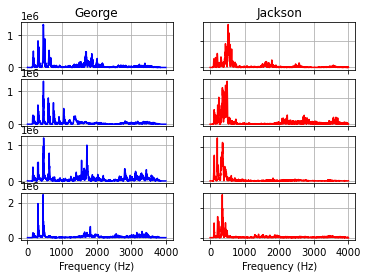

In [16]:
george_samples = np.where(y == 0)[
    0
]  # Find entries in y that are equal to 0 (and are therefore George)
jackson_samples = np.where(y == 1)[
    0
]  # Find entries in y that are equal to 1 (and are therefore Jackson)

# Shuffle these for variety
np.random.seed(42)
np.random.shuffle(george_samples)
np.random.shuffle(jackson_samples)

# Subplot of some George and Jackson frequency spectra
fig, axs = plt.subplots(4, 2)
axs[0, 0].set_title("George")
axs[0, 1].set_title("Jackson")
for i in range(4):
    axs[i, 0].plot(X[george_samples[i]], color="b")
    axs[i, 1].plot(X[jackson_samples[i]], color="r")

for ax in axs.flat:
    ax.set(xlabel="Frequency (Hz)")
    ax.grid()

for ax in axs.flat:
    ax.label_outer()

There are differences between clips from George and Jackson. Notice that George has some higher frequencies in his voice than Jackson does. However, the unnormalised magnitudes are problematic. Some frequencies have values in the millions! We should standardise this data so that they don't dominate later on.

<hr style="border:2px solid blue"> </hr>


**Q3: Create a dataset matrix $\mathbf{X}_s$ that is a standardised version of $\mathbf{X}$. Assign it to a variable called `X_s`.**

**[2 marks]**

In [17]:
"""Write your solution here. You must use the correct variable name to get marks."""
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_s = scaler.fit_transform(X, 1e-8) # Standardise

# column_means = X.mean(0) # This means take the mean across columns
# column_stds = X.std(0) # This means take the std across columns

# # Standardise
# eps = 1e-8
# X_s = (X - column_means)/(column_stds + eps) # Standardise
print(X_s)

[[ 0.88063463  7.44423706  8.81487315 ... -0.4482109  -0.39252151
  -0.30709852]
 [ 0.49794575  0.0965983  -0.51937957 ... -0.49421396 -0.49425867
  -0.44523056]
 [ 1.03797883 -0.20050024 -0.21243196 ... -0.46730102 -0.45222632
  -0.43217267]
 ...
 [-0.66451518 -0.61738951 -0.15957495 ... -0.2516819  -0.15386824
  -0.10137266]
 [-1.19213941 -0.47854335 -0.15521751 ...  0.05863939  0.50098363
   0.36295072]
 [-1.1966066   0.29381343 -0.18613918 ...  1.58127615  1.56626551
   1.43433819]]


In [18]:
"""Please pay no attention to this cell"""


'Please pay no attention to this cell'

<hr style="border:2px solid blue"> </hr>



### 2. Principal Component Analysis (PCA)

Our data points exist in 4001-D dimensions. This is quite big, and we can't visualise the dataset as a whole. We can turn to PCA to reduce our data to a lower dimensional space, while retaining as much variation as possible.

In short, we want to form a reduced dimensionality dataset $\mathbf{X}_d\in \mathbb{R}^{1000\times d}$ where $d<4001$.

To perform PCA to reduce a standardised dataset $\mathbf{X}_{s}$ to $d$ dimensions:
1. Form $\mathbf{\Sigma} =\frac{1}{N}\mathbf{X^T}_{s}\mathbf{X}_{s}$
2. Compute the eigenvalues/vectors of $\mathbf{\Sigma}$ ensuring that they are unit norm.
3. Form the matrix $\mathbf{W}$ that consists of $d$ columns which are the first $d$ eigenvectors of $\mathbf{\Sigma}$
4. Compute  $\mathbf{X}_{d}=\mathbf{X}_{s}$$\mathbf{W}$  

However, in this case $\mathbf{\Sigma}$ is a 4001 by 4001 matrix, and eigendecomposing this is fairly expensive. We will load in the first **10** pre-computed eigenvalues/vectors of $\mathbf{\Sigma}$ to save time. However, the code used to produce these is given below for completeness:

```
# The following code was used to get these eigenvalues and eigenvectors.
# It is expensive to run and takes a few minutes. You do not need to run it!

Sigma = (1 / 1000) * X_s.T @ X_s
eigenvalues, eigenvectors = np.linalg.eig(Sigma)

# Take the real parts
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

# Keep the first 10 eigenvalues/vectors
eigenvalues = eigenvalues[0:10]
eigenvectors = eigenvectors[:, 0:10]
```

In [19]:
import numpy as np

eigenvalues = np.load("npy/Sigma_eigenvalues.npy")
eigenvectors = np.load("npy/Sigma_eigenvectors.npy")

<hr style="border:2px solid blue"> </hr>


**Q4: Use these eigenvectors to form the matrix $\mathbf{W}$ to transform our dataset for $d=2$. Perform this transformation to create $\mathbf{X}_{d}$ and assign it to a variable `X_d`. Then, produce a scatter plot of the transformed dataset with the two classes in different colours.**

*Hint: You will need to use `y` to determine which data points belong to which class (speaker).*

**[3 marks]**


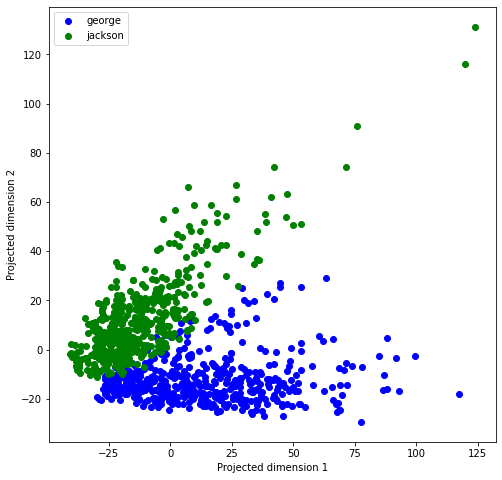

In [36]:
"""Write your solution here"""

W = eigenvectors[:, :2]
X_d = X_s.dot(W)

fig, ax = plt.subplots(figsize=[8, 8])

ax.scatter(X_d[y == 0, 0], X_d[y == 0, 1], color="b")
ax.scatter(X_d[y == 1, 0], X_d[y == 1, 1], color="g")

# Label axes and include a legend
ax.set_xlabel("Projected dimension 1")
ax.set_ylabel("Projected dimension 2")
ax.legend(['george', 'jackson'])


<hr style="border:2px solid blue"> </hr>



Hopefully you can see that in 2D, our data points from our two speakers lie in largely distinct regions of space. Recall that linear and classifiers work by finding a line to separate data from the two classes.

Before we learn the classifiers, however, there is the matter of splitting the dataset into training, validation, and test sets (as well as performing some post-PCA standardisation). This will all be done in the code block below.

In [21]:
# Re-normalise data (small numbers are nicer)
X_d = (X_d - X_d.mean(0)) / (X_d.std(0) + 1e-8)

# Split into train/val/test at ratio 400/200/400

np.random.seed(42)  # Set a random seed
indices = np.array([i for i in range(1000)])  # The numbers 0-999
np.random.shuffle(indices)  # Shuffle data before splitting.

X_train = X_d[indices[0:400]]
X_val = X_d[indices[400:600]]
X_test = X_d[indices[600:]]

y_train = y[indices[0:400]]
y_val = y[indices[400:600]]
y_test = y[indices[600:]]

We now have variables `X_train`, `y_train` that contain the data points and class labels for the training set.

Similarly we have  `X_val`, `y_val` for validation, and  `X_test`, `y_test` for test.

<div class="alert alert-danger">
<b>It is important that you have the correct arrays for the rest of the notebook. If you are not confident that yours are correct, then you may uncomment and run the cell below to get the correct ones.</b>
</div>

In [22]:
# del X_train, X_val, X_test, y_train, y_val, y_test
# X_train = np.load("npy/X_train.npy")
# X_val = np.load("npy/X_val.npy")
# X_test = np.load("npy/X_test.npy")
# y_train = np.load("npy/y_train.npy")
# y_val = np.load("npy/y_val.npy")
# y_test = np.load("npy/y_test.npy")


### 3. $k$-Nearest Neighbour ($k$-NN) classification


The simplest classifier is a $k$-Nearest Neighbours classifier. This does not have any parameters, and has a single hyperparameter $k$.

To classify a new point $\mathbf{x}^{(t)}$:
    
1. Compute the L2 distance between $\mathbf{x}^{(t)}$ and each training point
2. Identify the $k$ closest points to $\mathbf{x}^{(t)}$ - those with the lowest L2 distances from it
3. Assign $\mathbf{x}^{(t)}$ to the most prevalent class of its nearest neighbours

Let's briefly recap what our data splits are used for.

- **Training set**: This is used for training the parameters of the classifier. ($k$-NN has no parameters, but the training set is used to compute nearest neighbours)

- **Validation set**: This is used to calibrate the hyperparameters of the classifier.

- **Test set**: This is used to evaluate the classifier.

**Important:** The whole reason we are learning a classifier is so it can be applied to new data, and we use the test data to simulate this scenario. This is why we use the training set to learn parameters, and the validation set to calibrate hyperparameters. **We are not allowed to train or calibrate on the test set**, as we would not have access to new data in real life. 


<hr style="border:2px solid blue"> </hr>


**Q5: Perform $k$-NN classification on the validation set using the training set for $k=1$, $k=3$ and $k=13$. Compute validation accuracy as a percentage for each of these, and assign these values to the variables `val_k1`, `val_k3` and `val_k13` respectively.**


**[3 marks]**

In [23]:
"""Write your solution here. You must use the correct variable names to get marks."""

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# create an instance of KNeighborsClassifier with k=1
k1 = KNeighborsClassifier(n_neighbors=1)

# fit the classifier on the training set
k1.fit(X_train, y_train)

# predict the labels of the validation set using the fitted classifier
y_pred_k1 = k1.predict(X_val)

# compute the validation accuracy for k=1
val_k1 = accuracy_score(y_val, y_pred_k1)*100

# create an instance of KNeighborsClassifier with k=3
k3 = KNeighborsClassifier(n_neighbors=3)

# fit the classifier on the training set
k3.fit(X_train, y_train)

# predict the labels of the validation set using the fitted classifier
y_pred_k3 = k3.predict(X_val)

# compute the validation accuracy for k=3
val_k3 = accuracy_score(y_val, y_pred_k3)*100

# create an instance of KNeighborsClassifier with k=13
k13 = KNeighborsClassifier(n_neighbors=13)

# fit the classifier on the training set
k13.fit(X_train, y_train)

# predict the labels of the validation set using the fitted classifier
y_pred_k13 = k13.predict(X_val)

# compute the validation accuracy for k=13
val_k13 = accuracy_score(y_val, y_pred_k13)*100

# print the validation accuracies


In [24]:
"""You can run this cell to check your val_k1 value"""
try:
    print(f"val_k1 = {val_k1}")
except NameError:
    print("The variable val_k1 does not exist")


val_k1 = 93.5


In [25]:
"""You can run this cell to check your val_k3 value"""
try:
    print(f"val_k3 = {val_k3}")
except NameError:
    print("The variable val_k3 does not exist")

val_k3 = 95.5


In [26]:
"""You can run this cell to check your val_k13 value"""
try:
    print(f"val_k13 = {val_k13}")
except NameError:
    print("The variable val_k13 does not exist")

val_k13 = 96.0


<hr style="border:2px solid blue"> </hr>


**Q6: Perform $k$-NN classification on the test set using the training set for the value of $k$ above with the highest validation accuracy. Compute test accuracy as a percentage and assign the value to the variable `test_acc`**.
    
    


**[1 mark]**

In [27]:
"""Write your solution here. You must use the correct variable name to get marks."""
# I use the K value of 13 because that was the best validation accuracy result from above

# create an instance of KNeighborsClassifier with k=13
k_best = KNeighborsClassifier(n_neighbors=13)

# fit the classifier on the training set
k_best.fit(X_train, y_train)

# predict the labels of the test set using the fitted classifier
y_pred_k_best = k_best.predict(X_test)

# compute the test accuracy for k=13
test_acc = accuracy_score(y_test, y_pred_k_best)*100


In [28]:
"""You can run this cell to check your test_acc value"""
try:
    print(f"test_acc = {test_acc}")
except NameError:
    print("The variable test_acc does not exist")

test_acc = 97.5


<hr style="border:2px solid blue"> </hr>

### 4. Linear Classification

A linear classifier looks like $f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}+b $ where $\mathbf{w}\in \mathbb{R}^{D}$  are the learnable weight parameters, and $b \in \mathbb{R}^{1}$ is a learnable bias parameter. It can take in some data point $\mathbf{x}$ and then its output $f(\mathbf{x})$ can be used to make a class prediction according to some threshold function like 

$$\hat{y}=\begin{cases}
          1 \quad &\text{if} \, f(\mathbf{x}) \geq t \\
          0 \quad &\text{if} \, f(\mathbf{x})<t \\
     \end{cases}$$
     
However, the weights and bias need to be learnt. This is done by solving $\underset{\mathbf{w},b}{\mathrm{minimise }}\ L$ where $L$ is some loss function. 

In this assignment, we are interested in minimising the cross entropy loss $L_{CE} =- \frac{1}{N}\sum_{n=1} ^{N} \Big[y^{(n)} \log \sigma(f(\mathbf{x}^{(n)}))+({1-y^{(n)}})\log(1- \sigma(f(\mathbf{x}^{(n)}))\Big]$ where $\sigma$ is the sigmoid function. Minimising this loss function is performing *logistic regression*.

<hr style="border:2px solid blue"> </hr>

**Q6 Train a linear classifier by performing logistic regression. Use $\alpha = 0.1$ for 500 iterations. You do not need to use the validation set for this question. Print the test accuracy and comment on how it compares to your $k$-NN result above.**

**[4 marks]**

In [32]:
"""Write your solution here"""
# I created a linear classifier class below that performs logistic regression on the training data set that is inputted into the
# fit() method below. It has a constructor class with alpha and num_iters params which plays a crucial role in determining the 
# accuracy resul tin the end. More numbe of iterators, the higher the accurcy score.
class LinearClassifier:
    def __init__(self, alpha, num_iters): # Constructor with alpha and num_iters
        self.alpha = alpha
        self.num_iters = num_iters
        self.weights = None
    
    def sigmoid(self, z): # method that does the sigmoid function
        return 1 / (1 + np.exp(-z))
    
    def add_bias_term(self, X): # Adds the bias term to the training data set that is inputed
        return np.insert(X, 0, 1, axis=1)
    
    def fit(self, X, y): # Input the trainnig data sets to have logistic regeression perfomed on them based on the num_iters and alpha
        # Add bias term to X
        X = self.add_bias_term(X)
        
        # Initialize weights randomly
        np.random.seed(42)
        self.weights = np.random.randn(X.shape[1])
        
        # Gradient descent to minimize loss
        for i in range(self.num_iters):
            z = np.dot(X, self.weights)
            y_hat = self.sigmoid(z)
            error = y_hat - y
            gradient = np.dot(X.T, error) / y.size
            self.weights -= self.alpha * gradient
    
    def predict(self, X):
        # Add bias term to X
        X = self.add_bias_term(X)
        
        # Predict class labels using learned weights
        y_hat = self.sigmoid(np.dot(X, self.weights))
        return (y_hat >= 0.5).astype(int)



clf = LinearClassifier(0.1, 500)
clf.fit(X_train, y_train)

# Predict the labels for the testing data
y_pred = clf.predict(X_test)

# Print the accuracy of the model
test_accuracy = np.mean(y_pred == y_test)*100
print("Test Accuracy:", test_accuracy)

'''The test accuracy after performing the logistic regression is 1% lower than that perfmoed by the K-NN classifiers on the X_test set
Logistic regression is linear while k-nn looks for the lcosest neighbours so it works best for more complex data sets such as this one. '''

Test Accuracy: 96.5


<hr style="border:2px solid blue"> </hr>


**Q7: Plot the decision boundary of your classifier alongside the test data.**


**[3 marks]**

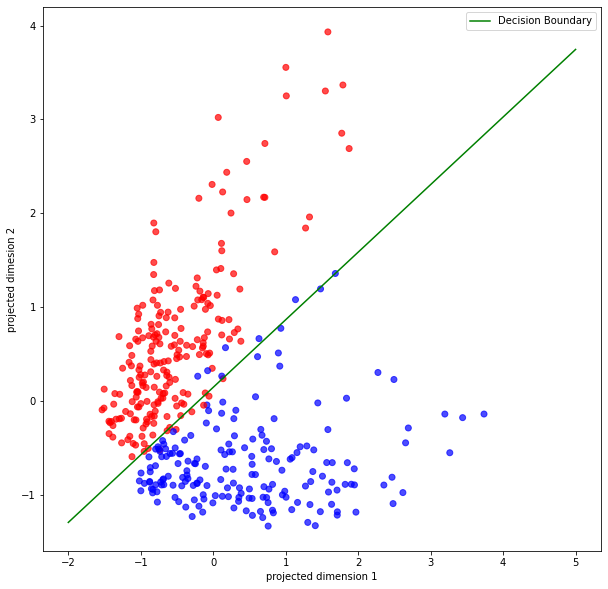

In [38]:
"""Write your solution here"""
# Compute decision boundary using learned weights
w = clf.weights
x1 = np.linspace(-2, 5, 10)
x2 = -(w[0] + w[1]*x1) / w[2]

# Plot the data points and decision boundary
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='bwr', alpha=0.7)
ax.plot(x1, x2, '-g', label='Decision Boundary')
ax.set_xlabel('projected dimension 1')
ax.set_ylabel('projected dimesion 2')
ax.legend()
plt.show()


<hr style="border:2px solid blue"> </hr>



**End of Assignment**
